In [ ]:
# import required packages (fill in the blanks!)
# you may not use all of these
!pip -q install matplotlib
!pip -q install scikit-learn
!pip -q install mne
!pip -q install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.8 MB/s eta 0:00:00


In [ ]:
import mne
from mne.time_frequency import psd_array_welch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
# bunch of stuff for svm analysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from the files tab, copy your specific file path
file_path = '/content/drive/MyDrive/Files_CortexCodec/S001R03.edf'

In [ ]:
raw = mne.io.read_raw_edf(file_path, preload=True)
raw.filter(1, 40)
raw.info

Extracting EDF parameters from /content/drive/MyDrive/Files_CortexCodec/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 40.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

In [ ]:
# https://mne.tools/stable/generated/mne.preprocessing.ICA.html
from mne.preprocessing import ICA

ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter=800)


# lets fit and apply our ICA model to our raw data as usual
ica.fit(raw)
raw_clean = ica.apply(raw.copy())

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 28.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [ ]:
events, event_id = mne.events_from_annotations(raw_clean)

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]


In [ ]:
print(event_id)

{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


In [ ]:
event_dict = {'left_fist': 2, 'right_fist': 3}
epochs = mne.Epochs(raw_clean, events, event_id=event_dict, tmin=0, tmax=3, preload=True, baseline = None)

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 481 original time points ...
0 bad epochs dropped


In [ ]:
X = epochs.get_data()
y = epochs.events[:, -1]

In [ ]:
print(f"Shape: {X.shape}, Labels: {np.unique(y)}")
# shape should be like (n_epochs, n_channels, n_times)

Shape: (15, 64, 481), Labels: [2 3]


In [ ]:
sfreq = raw.info['sfreq']
freq_bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta':  (13, 30),
    'gamma': (30, 40),
}

In [ ]:
def bandpower(data, sfreq, band):
    fmin, fmax = band
    #fmin = lower bound of the band and fmax = upper bound of the band (ex. fmin delta = 1 and fmax delta = 4)
    psd, freqs = psd_array_welch(data, sfreq, fmin, fmax, n_fft=256)
    #psd_array_welch: MNE function that does the PSD of the EEG signal using the Welch method
    return np.mean(psd, axis=-1)

In [ ]:
freq_band_features = []

In [ ]:
for name, (fmin, fmax) in freq_bands.items():
    bp = bandpower(X, sfreq, (fmin, fmax))
    freq_band_features.append(bp)

Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)


In [ ]:
X_features = np.concatenate(freq_band_features, axis=1)
print("Feature matrix shape:", X_features.shape)

Feature matrix shape: (15, 320)


In [ ]:
# normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=42, stratify=y)

In [ ]:
svm = SVC(kernel="linear", C=1)
svm.fit(X_train, y_train)
svm_acc = svm.score(X_test, y_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_acc = knn.score(X_test, y_test)

print(f"SVM accuracy: {svm_acc}")
print(f"KNN accuracy: {knn_acc}")

SVM accuracy: 0.375
KNN accuracy: 0.25


In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

<Figure size 1200x500 with 0 Axes>

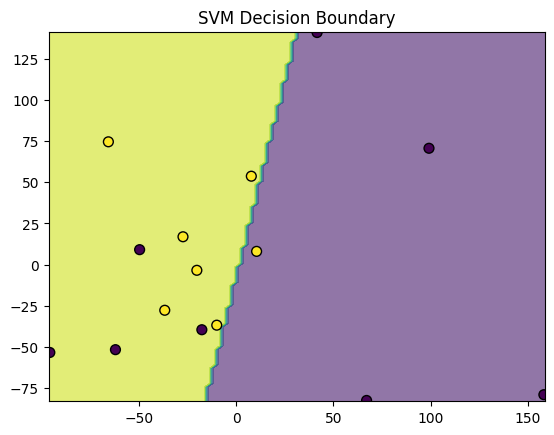

'\nplt.subplot(1,2,1)\nDecisionBoundaryDisplay.from_estimator(\n    svm_2d, X_pca, response_method="predict", alpha=0.6, cmap="Pastel1",\n    xlabel="PCA 1", ylabel="PCA 2"\n)\nplt.scatter(X_pca[:,0], X_pca[:,1], c=y, edgecolor="k", s=25)\nplt.title("SVM Decision Boundary")\n\nplt.subplot(1,2,2)\nDecisionBoundaryDisplay.from_estimator(\n    knn_2d, X_pca, response_method="predict", alpha=0.6, cmap="Pastel1",\n    xlabel="PCA 1", ylabel="PCA 2"\n)\nplt.scatter(X_pca[:,0], X_pca[:,1], c=y, edgecolor="k", s=25)\nplt.title("KNN Decision Boundary")\n\nplt.tight_layout()\nplt.show()\n'

In [ ]:
# make it 2D for graph analysis

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay

# Close any previous figures
plt.close('all')

# Train classifiers on PCA-reduced features (X_pca)
svm_2d = SVC(kernel="linear", C=1)
svm_2d.fit(X_pca, y)

knn_2d = KNeighborsClassifier(n_neighbors=5)
knn_2d.fit(X_pca, y)

# Determine plot limits based on PCA points
x_min, x_max = X_pca[:,0].min() - 0.5, X_pca[:,0].max() + 0.5
y_min, y_max = X_pca[:,1].min() - 0.5, X_pca[:,1].max() + 0.5

# Create figure
plt.figure(figsize=(12, 5))
DecisionBoundaryDisplay.from_estimator(svm_2d, X_pca, response_method="predict", alpha=0.6)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, edgecolor="k", s=50)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.title("SVM Decision Boundary")
plt.show()

'''
plt.subplot(1,2,1)
DecisionBoundaryDisplay.from_estimator(
    svm_2d, X_pca, response_method="predict", alpha=0.6, cmap="Pastel1",
    xlabel="PCA 1", ylabel="PCA 2"
)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, edgecolor="k", s=25)
plt.title("SVM Decision Boundary")

plt.subplot(1,2,2)
DecisionBoundaryDisplay.from_estimator(
    knn_2d, X_pca, response_method="predict", alpha=0.6, cmap="Pastel1",
    xlabel="PCA 1", ylabel="PCA 2"
)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, edgecolor="k", s=25)
plt.title("KNN Decision Boundary")

plt.tight_layout()
plt.show()
'''

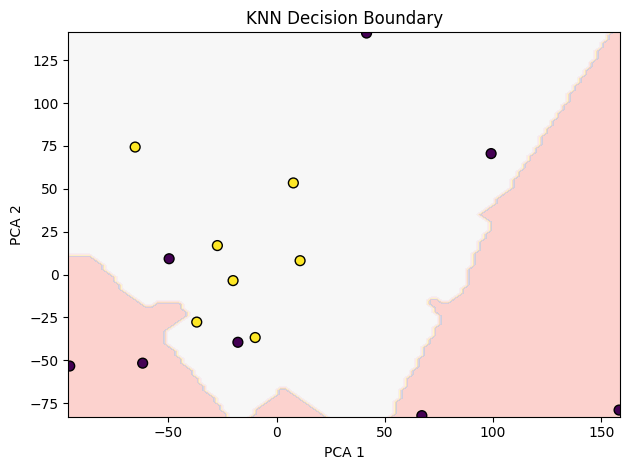

In [ ]:
DecisionBoundaryDisplay.from_estimator(
    knn_2d, X_pca, response_method="predict",
    alpha=0.6, cmap="Pastel1"
)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, edgecolor="k", s=50)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("KNN Decision Boundary")

plt.tight_layout()
plt.show()

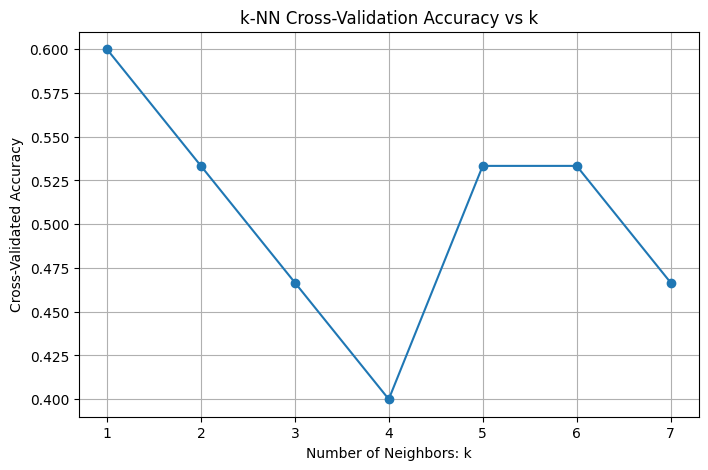

Best k from cross-validation: 1


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Range of k values to try, limited by the size of the training set
k_range = range(1, X_train.shape[0] + 1) # Max k can be X_train.shape[0]
cv_scores = []

# Evaluate each k using 5-fold cross-validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot accuracy vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_range, cv_scores, marker='o')
plt.title("k-NN Cross-Validation Accuracy vs k")
plt.xlabel("Number of Neighbors: k")
plt.ylabel("Cross-Validated Accuracy")
plt.grid(True)
plt.show()

# Best k - use nanargmax to correctly handle potential NaN values if present
best_k = k_range[np.nanargmax(cv_scores)]
print(f"Best k from cross-validation: {best_k}")

In [ ]:
# Train final model with best k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

# Predict on test data
y_pred = best_knn.predict(X_test)

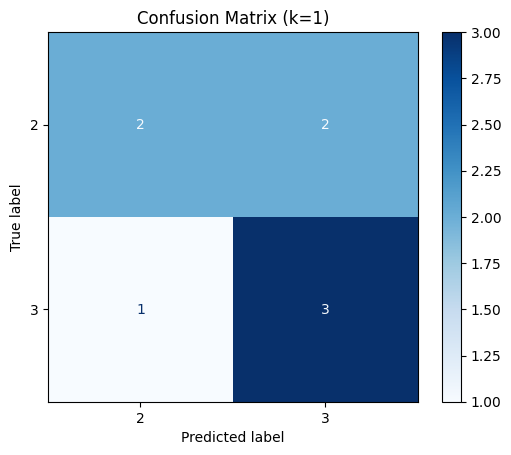

Classification Report:
              precision    recall  f1-score   support

           2       0.67      0.50      0.57         4
           3       0.60      0.75      0.67         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (k={best_k})")
plt.grid(False)
plt.show()

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(label) for label in np.unique(y)]))